In [4]:
%pip install pandas numpy matplotlib opencv-python scikit-learn tensorflow


     -------------------------------------- 11.6/11.6 MB 997.5 kB/s eta 0:00:00
     -------------------------------------- 12.9/12.9 MB 350.7 kB/s eta 0:00:00
     ---------------------------------------- 8.1/8.1 MB 302.6 kB/s eta 0:00:00
     ---------------------------------------- 39.5/39.5 MB 1.3 MB/s eta 0:00:00
     ---------------------------------------- 11.1/11.1 MB 1.2 MB/s eta 0:00:00
     ------------------------------------ 375.9/375.9 MB 539.7 kB/s eta 0:00:00
     -------------------------------------- 509.2/509.2 kB 1.8 MB/s eta 0:00:00
     ------------------------------------ 347.8/347.8 kB 770.8 kB/s eta 0:00:00
     ------------------------------------ 222.0/222.0 kB 315.1 kB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 428.2 kB/s eta 0:00:00
     -------------------------------------- 72.0/72.0 kB 493.8 kB/s eta 0:00:00
     ---------------------------------------- 2.7/2.7 MB 641.5 kB/s eta 0:00:00
     -----------------------------------


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ Metadata loaded!
✅ Total images found: 112120
✅ Diseases retained for training: ['Pneumonia', 'Pneumothorax', 'Cardiomegaly', 'Pleural_thickening', 'Fibrosis', 'No Finding']
✅ Train: 57028, Validation: 14258
Found 57028 validated image filenames.
Found 14258 validated image filenames.
✅ Data generators ready!


c:\Users\sarth\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1783/1783 ━━━━━━━━━━━━━━━━━━━━ 14122s 8s/step - accuracy: 0.8291 - loss: 0.3916 - val_accuracy: 0.8468 - val_loss: 0.3076
Epoch 2/5
1783/1783 ━━━━━━━━━━━━━━━━━━━━ 10649s 6s/step - accuracy: 0.8459 - loss: 0.3118 - val_accuracy: 0.8468 - val_loss: 0.3098
Epoch 3/5
1783/1783 ━━━━━━━━━━━━━━━━━━━━ 10776s 6s/step - accuracy: 0.8476 - loss: 0.3098 - val_accuracy: 0.8468 - val_loss: 0.3067
Epoch 4/5
1783/1783 ━━━━━━━━━━━━━━━━━━━━ 13144s 7s/step - accuracy: 0.8471 - loss: 0.3096 - val_accuracy: 0.8468 - val_loss: 0.3065
Epoch 5/5
1783/1783 ━━━━━━━━━━━━━━━━━━━━ 11458s 6s/step - accuracy: 0.8474 - loss: 0.3091 - val_accuracy: 0.8468 - val_loss: 0.3061
✅ Model training complete!
446/446 ━━━━━━━━━━━━━━━━━━━━ 1283s 3s/step - accuracy: 0.8464 - loss: 0.3060


✅ Final Accuracy: 0.8468
✅ Model saved at: C:\Users\sarth\Downloads\lathaproject\efficientnetb4_multilabel.h5


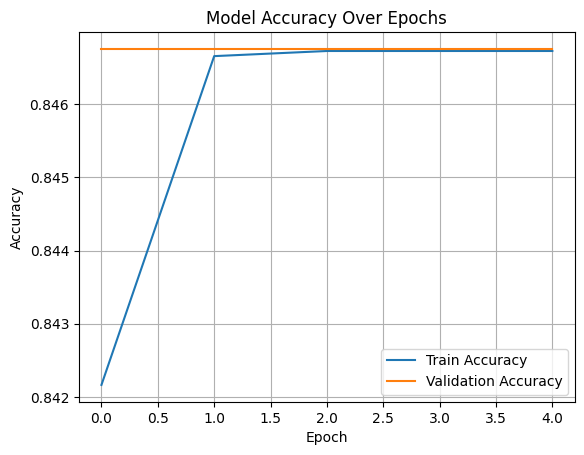

In [11]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

# ✅ Step 1: Set up paths
BASE_DIR = r"C:\Users\sarth\Downloads\lathaproject"
METADATA_PATH = os.path.join(BASE_DIR, "Data_Entry_2017.csv")

if not os.path.exists(METADATA_PATH):
    raise FileNotFoundError(f"Metadata file not found at {METADATA_PATH}")

# ✅ Step 2: Load metadata
metadata = pd.read_csv(METADATA_PATH)
print("✅ Metadata loaded!")

# ✅ Step 3: Collect all image paths
image_paths, labels = [], []
for folder in os.listdir(BASE_DIR):
    if folder.startswith("images_"):
        folder_path = os.path.join(BASE_DIR, folder, "images")
        if not os.path.exists(folder_path):
            continue
        for image_file in os.listdir(folder_path):
            if image_file.endswith(".png"):
                image_path = os.path.join(folder_path, image_file)
                image_paths.append(image_path)
                label_row = metadata.loc[metadata["Image Index"] == image_file, "Finding Labels"].values
                labels.append(label_row[0].split("|") if len(label_row) > 0 else ["No Finding"])

print(f"✅ Total images found: {len(image_paths)}")

# ✅ Step 4: Convert to DataFrame
df = pd.DataFrame({"Image Path": image_paths, "Finding Labels": labels})

# ✅ Step 5: Select 6 most important diseases
IMPORTANT_DISEASES = ["Pneumonia", "Pneumothorax", "Cardiomegaly", "Pleural_thickening", "Fibrosis", "No Finding"]
for disease in IMPORTANT_DISEASES:
    df[disease] = df["Finding Labels"].apply(lambda x: 1 if disease in x else 0)

df = df.drop_duplicates(subset=["Image Path"])
df = df[df[IMPORTANT_DISEASES].sum(axis=1) > 0]

print(f"✅ Diseases retained for training: {IMPORTANT_DISEASES}")

# ✅ Step 6: Split dataset
df["Stratify_Label"] = df[IMPORTANT_DISEASES].idxmax(axis=1)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["Stratify_Label"], random_state=42)

print(f"✅ Train: {len(train_df)}, Validation: {len(val_df)}")

# ✅ Step 7: Data Generators
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col="Image Path", y_col=IMPORTANT_DISEASES,
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="raw"
)

val_generator = val_datagen.flow_from_dataframe(
    val_df, x_col="Image Path", y_col=IMPORTANT_DISEASES,
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="raw"
)

print("✅ Data generators ready!")

# ✅ Step 8: Load EfficientNetB4 & fine-tune last layers
base_model = EfficientNetB4(input_shape=IMG_SIZE + (3,), include_top=False, weights="imagenet")
base_model.trainable = False

def unfreeze_model(model, trainable_layers=150):
    for layer in model.layers[-trainable_layers:]:
        layer.trainable = True

unfreeze_model(base_model, trainable_layers=150)

# ✅ Step 9: Build full model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(len(IMPORTANT_DISEASES), activation="sigmoid")
])

# ✅ Step 10: Compile model
lr_schedule = CosineDecay(initial_learning_rate=1e-3, decay_steps=1000, alpha=0.1)

model.compile(
    optimizer=AdamW(learning_rate=lr_schedule),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

# ✅ Step 11: Train model
callbacks = [EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)]

history = model.fit(train_generator, validation_data=val_generator, epochs=5, callbacks=callbacks)
print("✅ Model training complete!")

# ✅ Step 12: Evaluate and Save Model
loss, accuracy = model.evaluate(val_generator)
print(f"✅ Final Accuracy: {accuracy:.4f}")

MODEL_SAVE_PATH = os.path.join(BASE_DIR, "efficientnetb4_multilabel.h5")
model.save(MODEL_SAVE_PATH)
print(f"✅ Model saved at: {MODEL_SAVE_PATH}")

# ✅ Step 13: Plot Training History
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy Over Epochs")
plt.grid(True)
plt.show()



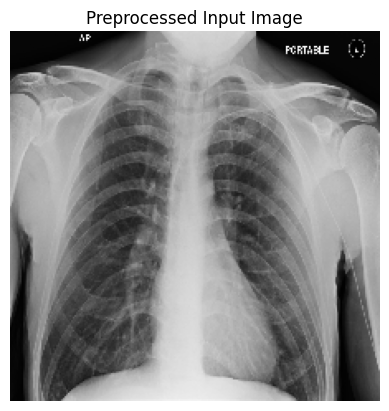

In [33]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Define image size
IMG_SIZE = (224, 224)

# Function to preprocess an image
def preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# ✅ Provide a specific image path manually (update to your actual path)
sample_image_path = r"C:\Users\sarth\Downloads\lathaproject\images_011\images\00028168_002.png"

# Preprocess it
img_input = preprocess_image(sample_image_path)

# Optional: Visual check
plt.imshow(img_input[0])
plt.axis("off")
plt.title("Preprocessed Input Image")
plt.show()


C:\Users\sarth\AppData\Local\Temp\ipykernel_20848\944899085.py:25: RuntimeWarning: invalid value encountered in divide
  saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())


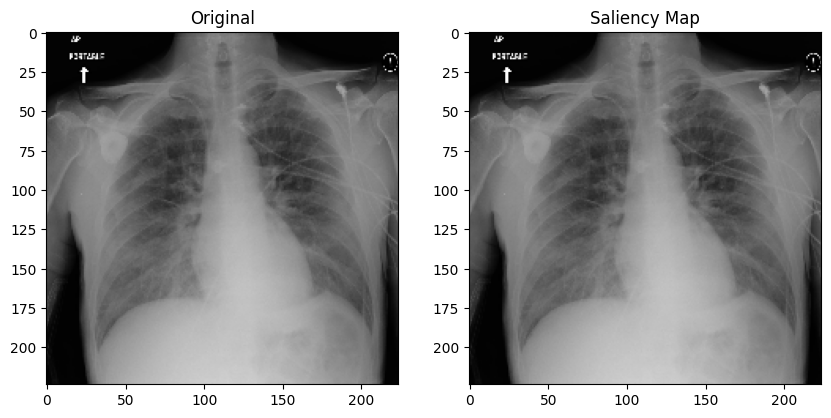

In [48]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def generate_saliency(image_path, model, class_idx=0):
    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    
    # Convert to tensor
    img_tensor = tf.convert_to_tensor(img_array)
    
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        class_output = preds[:, class_idx]  # For multi-label
    
    # Get gradients
    grads = tape.gradient(class_output, img_tensor)[0]
    
    # Process and visualize
    saliency = np.max(np.abs(grads), axis=-1)
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(saliency, cmap='hot', alpha=0.5)
    plt.title('Saliency Map')
    plt.show()

# Usage
generate_saliency(r"C:\Users\sarth\Downloads\lathaproject\images_008\images\00018387_026.png", model, class_idx=0)

In [52]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image


# Load your saved model
model_path = r"C:\Users\sarth\Downloads\lathaproject\efficientnetb4_multilabel.h5"
model = tf.keras.models.load_model(model_path)

# Verify model summary
print(model.summary())

# Check input shape
input_shape = model.input_shape[1:3]
print(f"Model expects input shape: {input_shape}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 7, 7, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1792)           │         7,168 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       918,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,602,086 (70.96 MB)

 Trainable params: 14,837,310 (56.60 MB)

 Non-trainable params: 3,764,775 (14.36 MB)

 Optimizer params: 1 (8.00 B)

None
Model expects input shape: (224, 224)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Generating occlusion map:   0%|          | 0/441 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Generating occlusion map:   0%|          | 1/441 [00:00<02:48,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


Generating occlusion map:   0%|          | 2/441 [00:00<03:12,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating occlusion map:   1%|          | 3/441 [00:01<02:48,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Generating occlusion map:   1%|          | 4/441 [00:01<02:23,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Generating occlusion map:   1%|          | 5/441 [00:01<02:13,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating occlusion map:   1%|▏         | 6/441 [00:02<02:14,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Generating occlusion map:   2%|▏         | 7/441 [00:02<02:10,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Generating occlusion map:   2%|▏         | 8/441 [00:02<02:09,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating occlusion map:   2%|▏         | 9/441 [00:02<02:23,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Generating occlusion map:   2%|▏         | 10/441 [00:03<02:20,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Generating occlusion map:   2%|▏         | 11/441 [00:03<02:20,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


Generating occlusion map:   3%|▎         | 12/441 [00:04<02:43,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Generating occlusion map:   3%|▎         | 13/441 [00:04<02:46,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


Generating occlusion map:   3%|▎         | 14/441 [00:05<03:02,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Generating occlusion map:   3%|▎         | 15/441 [00:05<02:56,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Generating occlusion map:   4%|▎         | 16/441 [00:05<02:30,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating occlusion map:   4%|▍         | 17/441 [00:06<02:49,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Generating occlusion map:   4%|▍         | 18/441 [00:06<02:30,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


Generating occlusion map:   4%|▍         | 19/441 [00:06<02:53,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


Generating occlusion map:   5%|▍         | 20/441 [00:07<03:35,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Generating occlusion map:   5%|▍         | 21/441 [00:08<03:32,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


Generating occlusion map:   5%|▍         | 22/441 [00:08<03:34,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Generating occlusion map:   5%|▌         | 23/441 [00:09<03:35,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Generating occlusion map:   5%|▌         | 24/441 [00:09<03:19,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


Generating occlusion map:   6%|▌         | 25/441 [00:10<03:13,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Generating occlusion map:   6%|▌         | 26/441 [00:10<03:11,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Generating occlusion map:   6%|▌         | 27/441 [00:10<03:01,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating occlusion map:   6%|▋         | 28/441 [00:11<02:52,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Generating occlusion map:   7%|▋         | 29/441 [00:11<02:40,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


Generating occlusion map:   7%|▋         | 30/441 [00:12<02:49,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Generating occlusion map:   7%|▋         | 31/441 [00:12<02:42,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


Generating occlusion map:   7%|▋         | 32/441 [00:12<02:47,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Generating occlusion map:   7%|▋         | 33/441 [00:13<02:59,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Generating occlusion map:   8%|▊         | 34/441 [00:13<02:54,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


Generating occlusion map:   8%|▊         | 35/441 [00:14<02:53,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


Generating occlusion map:   8%|▊         | 36/441 [00:14<03:15,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


Generating occlusion map:   8%|▊         | 37/441 [00:16<05:09,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Generating occlusion map:   9%|▊         | 38/441 [00:16<04:22,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating occlusion map:   9%|▉         | 39/441 [00:16<03:41,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Generating occlusion map:   9%|▉         | 40/441 [00:17<03:10,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Generating occlusion map:   9%|▉         | 41/441 [00:17<03:03,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating occlusion map:  10%|▉         | 42/441 [00:18<02:54,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating occlusion map:  10%|▉         | 43/441 [00:18<02:40,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Generating occlusion map:  10%|▉         | 44/441 [00:18<02:35,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


Generating occlusion map:  10%|█         | 45/441 [00:19<02:31,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Generating occlusion map:  10%|█         | 46/441 [00:19<02:30,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Generating occlusion map:  11%|█         | 47/441 [00:19<02:46,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


Generating occlusion map:  11%|█         | 48/441 [00:20<02:50,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating occlusion map:  11%|█         | 49/441 [00:20<02:43,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


Generating occlusion map:  11%|█▏        | 50/441 [00:21<03:59,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Generating occlusion map:  12%|█▏        | 51/441 [00:22<03:33,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Generating occlusion map:  12%|█▏        | 52/441 [00:22<02:50,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Generating occlusion map:  12%|█▏        | 53/441 [00:22<02:19,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Generating occlusion map:  12%|█▏        | 54/441 [00:22<01:59,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Generating occlusion map:  12%|█▏        | 55/441 [00:23<01:42,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Generating occlusion map:  13%|█▎        | 56/441 [00:23<01:33,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Generating occlusion map:  13%|█▎        | 57/441 [00:23<01:25,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Generating occlusion map:  13%|█▎        | 58/441 [00:23<01:26,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Generating occlusion map:  13%|█▎        | 59/441 [00:23<01:29,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Generating occlusion map:  14%|█▎        | 60/441 [00:24<01:27,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Generating occlusion map:  14%|█▍        | 61/441 [00:24<01:24,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Generating occlusion map:  14%|█▍        | 62/441 [00:24<01:22,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Generating occlusion map:  14%|█▍        | 63/441 [00:24<01:19,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Generating occlusion map:  15%|█▍        | 64/441 [00:24<01:19,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Generating occlusion map:  15%|█▍        | 65/441 [00:25<01:19,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Generating occlusion map:  15%|█▍        | 66/441 [00:25<01:19,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Generating occlusion map:  15%|█▌        | 67/441 [00:25<01:21,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Generating occlusion map:  15%|█▌        | 68/441 [00:25<01:22,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Generating occlusion map:  16%|█▌        | 69/441 [00:26<01:23,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Generating occlusion map:  16%|█▌        | 70/441 [00:26<01:23,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Generating occlusion map:  16%|█▌        | 71/441 [00:26<01:23,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Generating occlusion map:  16%|█▋        | 72/441 [00:26<01:34,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Generating occlusion map:  17%|█▋        | 73/441 [00:27<01:45,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Generating occlusion map:  17%|█▋        | 74/441 [00:27<01:45,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Generating occlusion map:  17%|█▋        | 75/441 [00:27<01:41,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Generating occlusion map:  17%|█▋        | 76/441 [00:27<01:41,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating occlusion map:  17%|█▋        | 77/441 [00:28<01:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Generating occlusion map:  18%|█▊        | 78/441 [00:28<01:32,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating occlusion map:  18%|█▊        | 79/441 [00:28<01:32,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating occlusion map:  18%|█▊        | 80/441 [00:28<01:36,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Generating occlusion map:  18%|█▊        | 81/441 [00:29<01:48,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


Generating occlusion map:  19%|█▊        | 82/441 [00:29<02:12,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


Generating occlusion map:  19%|█▉        | 83/441 [00:30<02:26,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Generating occlusion map:  19%|█▉        | 84/441 [00:30<02:18,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating occlusion map:  19%|█▉        | 85/441 [00:31<02:09,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


Generating occlusion map:  20%|█▉        | 86/441 [00:31<02:41,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Generating occlusion map:  20%|█▉        | 87/441 [00:32<02:44,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Generating occlusion map:  20%|█▉        | 88/441 [00:32<02:16,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Generating occlusion map:  20%|██        | 89/441 [00:32<02:00,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Generating occlusion map:  20%|██        | 90/441 [00:32<01:46,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Generating occlusion map:  21%|██        | 91/441 [00:33<01:39,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Generating occlusion map:  21%|██        | 92/441 [00:33<01:29,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Generating occlusion map:  21%|██        | 93/441 [00:33<01:24,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Generating occlusion map:  21%|██▏       | 94/441 [00:33<01:24,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Generating occlusion map:  22%|██▏       | 95/441 [00:34<01:26,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Generating occlusion map:  22%|██▏       | 96/441 [00:34<01:27,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Generating occlusion map:  22%|██▏       | 97/441 [00:34<01:54,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Generating occlusion map:  22%|██▏       | 98/441 [00:35<01:45,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Generating occlusion map:  22%|██▏       | 99/441 [00:35<01:40,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Generating occlusion map:  23%|██▎       | 100/441 [00:35<01:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Generating occlusion map:  23%|██▎       | 101/441 [00:35<01:30,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Generating occlusion map:  23%|██▎       | 102/441 [00:36<01:25,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Generating occlusion map:  23%|██▎       | 103/441 [00:36<01:23,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Generating occlusion map:  24%|██▎       | 104/441 [00:36<01:20,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Generating occlusion map:  24%|██▍       | 105/441 [00:36<01:20,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Generating occlusion map:  24%|██▍       | 106/441 [00:36<01:15,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Generating occlusion map:  24%|██▍       | 107/441 [00:37<01:15,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating occlusion map:  24%|██▍       | 108/441 [00:37<01:24,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Generating occlusion map:  25%|██▍       | 109/441 [00:37<01:23,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Generating occlusion map:  25%|██▍       | 110/441 [00:37<01:22,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Generating occlusion map:  25%|██▌       | 111/441 [00:38<01:23,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Generating occlusion map:  25%|██▌       | 112/441 [00:38<01:21,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Generating occlusion map:  26%|██▌       | 113/441 [00:38<01:18,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Generating occlusion map:  26%|██▌       | 114/441 [00:38<01:18,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Generating occlusion map:  26%|██▌       | 115/441 [00:39<01:16,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Generating occlusion map:  26%|██▋       | 116/441 [00:39<01:13,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Generating occlusion map:  27%|██▋       | 117/441 [00:39<01:15,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Generating occlusion map:  27%|██▋       | 118/441 [00:39<01:23,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Generating occlusion map:  27%|██▋       | 119/441 [00:40<01:17,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Generating occlusion map:  27%|██▋       | 120/441 [00:40<01:12,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Generating occlusion map:  27%|██▋       | 121/441 [00:40<01:09,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Generating occlusion map:  28%|██▊       | 122/441 [00:40<01:08,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Generating occlusion map:  28%|██▊       | 123/441 [00:40<01:12,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Generating occlusion map:  28%|██▊       | 124/441 [00:41<01:10,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Generating occlusion map:  28%|██▊       | 125/441 [00:41<01:09,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Generating occlusion map:  29%|██▊       | 126/441 [00:41<01:08,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Generating occlusion map:  29%|██▉       | 127/441 [00:41<01:05,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Generating occlusion map:  29%|██▉       | 128/441 [00:42<01:12,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Generating occlusion map:  29%|██▉       | 129/441 [00:42<01:09,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Generating occlusion map:  29%|██▉       | 130/441 [00:42<01:07,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Generating occlusion map:  30%|██▉       | 131/441 [00:42<01:12,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Generating occlusion map:  30%|██▉       | 132/441 [00:42<01:14,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Generating occlusion map:  30%|███       | 133/441 [00:43<01:17,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Generating occlusion map:  30%|███       | 134/441 [00:43<01:16,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Generating occlusion map:  31%|███       | 135/441 [00:43<01:17,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Generating occlusion map:  31%|███       | 136/441 [00:43<01:15,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Generating occlusion map:  31%|███       | 137/441 [00:44<01:10,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Generating occlusion map:  31%|███▏      | 138/441 [00:44<01:13,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Generating occlusion map:  32%|███▏      | 139/441 [00:44<01:11,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Generating occlusion map:  32%|███▏      | 140/441 [00:44<01:13,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Generating occlusion map:  32%|███▏      | 141/441 [00:45<01:12,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Generating occlusion map:  32%|███▏      | 142/441 [00:45<01:08,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Generating occlusion map:  32%|███▏      | 143/441 [00:45<01:06,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Generating occlusion map:  33%|███▎      | 144/441 [00:45<01:05,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Generating occlusion map:  33%|███▎      | 145/441 [00:46<01:03,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Generating occlusion map:  33%|███▎      | 146/441 [00:46<01:05,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Generating occlusion map:  33%|███▎      | 147/441 [00:46<01:07,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating occlusion map:  34%|███▎      | 148/441 [00:46<01:18,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Generating occlusion map:  34%|███▍      | 149/441 [00:47<01:16,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Generating occlusion map:  34%|███▍      | 150/441 [00:47<01:17,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Generating occlusion map:  34%|███▍      | 151/441 [00:47<01:14,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Generating occlusion map:  34%|███▍      | 152/441 [00:47<01:11,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Generating occlusion map:  35%|███▍      | 153/441 [00:48<01:10,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Generating occlusion map:  35%|███▍      | 154/441 [00:48<01:09,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Generating occlusion map:  35%|███▌      | 155/441 [00:48<01:05,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Generating occlusion map:  35%|███▌      | 156/441 [00:48<01:08,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Generating occlusion map:  36%|███▌      | 157/441 [00:49<01:13,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating occlusion map:  36%|███▌      | 158/441 [00:49<01:16,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Generating occlusion map:  36%|███▌      | 159/441 [00:49<01:14,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Generating occlusion map:  36%|███▋      | 160/441 [00:49<01:23,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Generating occlusion map:  37%|███▋      | 161/441 [00:50<01:18,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Generating occlusion map:  37%|███▋      | 162/441 [00:50<01:12,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Generating occlusion map:  37%|███▋      | 163/441 [00:50<01:07,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Generating occlusion map:  37%|███▋      | 164/441 [00:50<01:11,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Generating occlusion map:  37%|███▋      | 165/441 [00:51<01:09,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Generating occlusion map:  38%|███▊      | 166/441 [00:51<01:07,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Generating occlusion map:  38%|███▊      | 167/441 [00:51<01:06,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Generating occlusion map:  38%|███▊      | 168/441 [00:51<01:04,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Generating occlusion map:  38%|███▊      | 169/441 [00:52<01:01,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Generating occlusion map:  39%|███▊      | 170/441 [00:52<00:59,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Generating occlusion map:  39%|███▉      | 171/441 [00:52<01:06,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Generating occlusion map:  39%|███▉      | 172/441 [00:52<01:04,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Generating occlusion map:  39%|███▉      | 173/441 [00:53<01:03,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Generating occlusion map:  39%|███▉      | 174/441 [00:53<01:01,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Generating occlusion map:  40%|███▉      | 175/441 [00:53<01:00,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Generating occlusion map:  40%|███▉      | 176/441 [00:53<01:01,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Generating occlusion map:  40%|████      | 177/441 [00:53<01:02,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Generating occlusion map:  40%|████      | 178/441 [00:54<01:02,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating occlusion map:  41%|████      | 179/441 [00:54<01:09,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Generating occlusion map:  41%|████      | 180/441 [00:54<01:13,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Generating occlusion map:  41%|████      | 181/441 [00:55<01:12,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Generating occlusion map:  41%|████▏     | 182/441 [00:55<01:08,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Generating occlusion map:  41%|████▏     | 183/441 [00:55<01:06,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Generating occlusion map:  42%|████▏     | 184/441 [00:55<01:04,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Generating occlusion map:  42%|████▏     | 185/441 [00:56<01:01,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Generating occlusion map:  42%|████▏     | 186/441 [00:56<01:01,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Generating occlusion map:  42%|████▏     | 187/441 [00:56<00:59,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Generating occlusion map:  43%|████▎     | 188/441 [00:56<00:55,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Generating occlusion map:  43%|████▎     | 189/441 [00:56<00:55,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Generating occlusion map:  43%|████▎     | 190/441 [00:57<01:03,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Generating occlusion map:  43%|████▎     | 191/441 [00:57<01:06,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Generating occlusion map:  44%|████▎     | 192/441 [00:57<01:04,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Generating occlusion map:  44%|████▍     | 193/441 [00:58<01:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Generating occlusion map:  44%|████▍     | 194/441 [00:58<01:06,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Generating occlusion map:  44%|████▍     | 195/441 [00:58<01:06,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Generating occlusion map:  44%|████▍     | 196/441 [00:58<01:06,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Generating occlusion map:  45%|████▍     | 197/441 [00:59<01:06,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Generating occlusion map:  45%|████▍     | 198/441 [00:59<01:02,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Generating occlusion map:  45%|████▌     | 199/441 [00:59<01:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Generating occlusion map:  45%|████▌     | 200/441 [00:59<01:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Generating occlusion map:  46%|████▌     | 201/441 [01:00<01:06,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Generating occlusion map:  46%|████▌     | 202/441 [01:00<01:05,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Generating occlusion map:  46%|████▌     | 203/441 [01:00<01:00,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Generating occlusion map:  46%|████▋     | 204/441 [01:00<00:57,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Generating occlusion map:  46%|████▋     | 205/441 [01:01<00:54,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Generating occlusion map:  47%|████▋     | 206/441 [01:01<00:51,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Generating occlusion map:  47%|████▋     | 207/441 [01:01<00:53,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Generating occlusion map:  47%|████▋     | 208/441 [01:01<00:55,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Generating occlusion map:  47%|████▋     | 209/441 [01:02<00:59,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Generating occlusion map:  48%|████▊     | 210/441 [01:02<01:06,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Generating occlusion map:  48%|████▊     | 211/441 [01:02<01:12,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Generating occlusion map:  48%|████▊     | 212/441 [01:03<01:08,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Generating occlusion map:  48%|████▊     | 213/441 [01:03<01:05,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Generating occlusion map:  49%|████▊     | 214/441 [01:03<01:02,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Generating occlusion map:  49%|████▉     | 215/441 [01:03<01:01,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Generating occlusion map:  49%|████▉     | 216/441 [01:04<00:59,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Generating occlusion map:  49%|████▉     | 217/441 [01:04<00:54,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Generating occlusion map:  49%|████▉     | 218/441 [01:04<00:52,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Generating occlusion map:  50%|████▉     | 219/441 [01:04<00:49,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Generating occlusion map:  50%|████▉     | 220/441 [01:05<00:55,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Generating occlusion map:  50%|█████     | 221/441 [01:05<00:53,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Generating occlusion map:  50%|█████     | 222/441 [01:05<00:52,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Generating occlusion map:  51%|█████     | 223/441 [01:05<01:01,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Generating occlusion map:  51%|█████     | 224/441 [01:06<01:02,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Generating occlusion map:  51%|█████     | 225/441 [01:06<01:14,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Generating occlusion map:  51%|█████     | 226/441 [01:06<01:03,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Generating occlusion map:  51%|█████▏    | 227/441 [01:07<00:58,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Generating occlusion map:  52%|█████▏    | 228/441 [01:07<01:02,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Generating occlusion map:  52%|█████▏    | 229/441 [01:07<01:04,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


Generating occlusion map:  52%|█████▏    | 230/441 [01:08<01:13,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Generating occlusion map:  52%|█████▏    | 231/441 [01:08<01:11,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Generating occlusion map:  53%|█████▎    | 232/441 [01:08<01:08,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Generating occlusion map:  53%|█████▎    | 233/441 [01:09<01:05,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Generating occlusion map:  53%|█████▎    | 234/441 [01:09<01:05,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Generating occlusion map:  53%|█████▎    | 235/441 [01:10<02:17,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Generating occlusion map:  54%|█████▎    | 236/441 [01:11<02:24,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Generating occlusion map:  54%|█████▎    | 237/441 [01:12<02:02,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Generating occlusion map:  54%|█████▍    | 238/441 [01:12<01:42,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Generating occlusion map:  54%|█████▍    | 239/441 [01:12<01:30,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Generating occlusion map:  54%|█████▍    | 240/441 [01:13<01:47,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Generating occlusion map:  55%|█████▍    | 241/441 [01:13<01:37,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


Generating occlusion map:  55%|█████▍    | 242/441 [01:14<02:09,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Generating occlusion map:  55%|█████▌    | 243/441 [01:15<01:55,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Generating occlusion map:  55%|█████▌    | 244/441 [01:15<01:30,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Generating occlusion map:  56%|█████▌    | 245/441 [01:15<01:18,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Generating occlusion map:  56%|█████▌    | 246/441 [01:15<01:10,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Generating occlusion map:  56%|█████▌    | 247/441 [01:16<01:15,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Generating occlusion map:  56%|█████▌    | 248/441 [01:17<01:28,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Generating occlusion map:  56%|█████▋    | 249/441 [01:17<01:30,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Generating occlusion map:  57%|█████▋    | 250/441 [01:17<01:19,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Generating occlusion map:  57%|█████▋    | 251/441 [01:18<01:06,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Generating occlusion map:  57%|█████▋    | 252/441 [01:18<01:03,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Generating occlusion map:  57%|█████▋    | 253/441 [01:18<00:53,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


Generating occlusion map:  58%|█████▊    | 254/441 [01:18<01:00,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Generating occlusion map:  58%|█████▊    | 255/441 [01:19<01:01,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating occlusion map:  58%|█████▊    | 256/441 [01:19<00:59,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Generating occlusion map:  58%|█████▊    | 257/441 [01:19<00:52,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Generating occlusion map:  59%|█████▊    | 258/441 [01:19<00:46,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Generating occlusion map:  59%|█████▊    | 259/441 [01:20<00:42,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Generating occlusion map:  59%|█████▉    | 260/441 [01:20<00:39,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Generating occlusion map:  59%|█████▉    | 261/441 [01:20<00:37,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Generating occlusion map:  59%|█████▉    | 262/441 [01:20<00:35,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Generating occlusion map:  60%|█████▉    | 263/441 [01:20<00:33,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Generating occlusion map:  60%|█████▉    | 264/441 [01:21<00:37,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Generating occlusion map:  60%|██████    | 265/441 [01:21<00:34,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Generating occlusion map:  60%|██████    | 266/441 [01:21<00:32,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Generating occlusion map:  61%|██████    | 267/441 [01:21<00:31,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Generating occlusion map:  61%|██████    | 268/441 [01:21<00:29,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Generating occlusion map:  61%|██████    | 269/441 [01:21<00:30,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Generating occlusion map:  61%|██████    | 270/441 [01:22<00:31,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Generating occlusion map:  61%|██████▏   | 271/441 [01:22<00:30,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Generating occlusion map:  62%|██████▏   | 272/441 [01:22<00:29,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Generating occlusion map:  62%|██████▏   | 273/441 [01:22<00:28,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Generating occlusion map:  62%|██████▏   | 274/441 [01:22<00:28,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Generating occlusion map:  62%|██████▏   | 275/441 [01:22<00:27,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Generating occlusion map:  63%|██████▎   | 276/441 [01:23<00:27,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Generating occlusion map:  63%|██████▎   | 277/441 [01:23<00:30,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Generating occlusion map:  63%|██████▎   | 278/441 [01:23<00:30,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Generating occlusion map:  63%|██████▎   | 279/441 [01:23<00:29,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Generating occlusion map:  63%|██████▎   | 280/441 [01:23<00:32,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Generating occlusion map:  64%|██████▎   | 281/441 [01:24<00:31,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Generating occlusion map:  64%|██████▍   | 282/441 [01:24<00:31,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Generating occlusion map:  64%|██████▍   | 283/441 [01:24<00:30,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Generating occlusion map:  64%|██████▍   | 284/441 [01:24<00:30,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Generating occlusion map:  65%|██████▍   | 285/441 [01:24<00:33,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Generating occlusion map:  65%|██████▍   | 286/441 [01:25<00:31,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Generating occlusion map:  65%|██████▌   | 287/441 [01:25<00:30,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Generating occlusion map:  65%|██████▌   | 288/441 [01:25<00:29,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Generating occlusion map:  66%|██████▌   | 289/441 [01:25<00:28,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Generating occlusion map:  66%|██████▌   | 290/441 [01:25<00:27,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Generating occlusion map:  66%|██████▌   | 291/441 [01:26<00:26,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Generating occlusion map:  66%|██████▌   | 292/441 [01:26<00:26,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Generating occlusion map:  66%|██████▋   | 293/441 [01:26<00:26,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Generating occlusion map:  67%|██████▋   | 294/441 [01:26<00:25,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Generating occlusion map:  67%|██████▋   | 295/441 [01:26<00:23,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Generating occlusion map:  67%|██████▋   | 296/441 [01:26<00:27,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Generating occlusion map:  67%|██████▋   | 297/441 [01:27<00:27,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Generating occlusion map:  68%|██████▊   | 298/441 [01:27<00:27,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Generating occlusion map:  68%|██████▊   | 299/441 [01:27<00:28,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Generating occlusion map:  68%|██████▊   | 300/441 [01:27<00:29,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Generating occlusion map:  68%|██████▊   | 301/441 [01:27<00:27,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Generating occlusion map:  68%|██████▊   | 302/441 [01:28<00:26,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Generating occlusion map:  69%|██████▊   | 303/441 [01:28<00:24,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Generating occlusion map:  69%|██████▉   | 304/441 [01:28<00:23,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Generating occlusion map:  69%|██████▉   | 305/441 [01:28<00:22,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Generating occlusion map:  69%|██████▉   | 306/441 [01:28<00:22,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Generating occlusion map:  70%|██████▉   | 307/441 [01:28<00:22,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Generating occlusion map:  70%|██████▉   | 308/441 [01:29<00:23,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Generating occlusion map:  70%|███████   | 309/441 [01:29<00:23,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Generating occlusion map:  70%|███████   | 310/441 [01:29<00:23,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Generating occlusion map:  71%|███████   | 311/441 [01:29<00:27,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Generating occlusion map:  71%|███████   | 312/441 [01:29<00:26,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Generating occlusion map:  71%|███████   | 313/441 [01:30<00:24,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Generating occlusion map:  71%|███████   | 314/441 [01:30<00:23,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Generating occlusion map:  71%|███████▏  | 315/441 [01:30<00:22,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Generating occlusion map:  72%|███████▏  | 316/441 [01:30<00:22,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Generating occlusion map:  72%|███████▏  | 317/441 [01:30<00:22,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Generating occlusion map:  72%|███████▏  | 318/441 [01:30<00:21,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Generating occlusion map:  72%|███████▏  | 319/441 [01:31<00:20,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Generating occlusion map:  73%|███████▎  | 320/441 [01:31<00:20,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Generating occlusion map:  73%|███████▎  | 321/441 [01:31<00:21,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Generating occlusion map:  73%|███████▎  | 322/441 [01:31<00:21,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Generating occlusion map:  73%|███████▎  | 323/441 [01:31<00:21,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Generating occlusion map:  73%|███████▎  | 324/441 [01:32<00:21,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Generating occlusion map:  74%|███████▎  | 325/441 [01:32<00:21,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Generating occlusion map:  74%|███████▍  | 326/441 [01:32<00:23,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Generating occlusion map:  74%|███████▍  | 327/441 [01:32<00:22,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Generating occlusion map:  74%|███████▍  | 328/441 [01:32<00:21,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Generating occlusion map:  75%|███████▍  | 329/441 [01:32<00:20,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Generating occlusion map:  75%|███████▍  | 330/441 [01:33<00:19,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Generating occlusion map:  75%|███████▌  | 331/441 [01:33<00:18,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Generating occlusion map:  75%|███████▌  | 332/441 [01:33<00:18,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Generating occlusion map:  76%|███████▌  | 333/441 [01:33<00:20,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Generating occlusion map:  76%|███████▌  | 334/441 [01:33<00:20,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Generating occlusion map:  76%|███████▌  | 335/441 [01:34<00:19,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Generating occlusion map:  76%|███████▌  | 336/441 [01:34<00:18,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Generating occlusion map:  76%|███████▋  | 337/441 [01:34<00:17,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Generating occlusion map:  77%|███████▋  | 338/441 [01:34<00:17,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Generating occlusion map:  77%|███████▋  | 339/441 [01:34<00:18,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Generating occlusion map:  77%|███████▋  | 340/441 [01:35<00:20,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Generating occlusion map:  77%|███████▋  | 341/441 [01:35<00:22,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Generating occlusion map:  78%|███████▊  | 342/441 [01:35<00:21,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Generating occlusion map:  78%|███████▊  | 343/441 [01:35<00:21,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Generating occlusion map:  78%|███████▊  | 344/441 [01:35<00:20,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Generating occlusion map:  78%|███████▊  | 345/441 [01:36<00:19,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Generating occlusion map:  78%|███████▊  | 346/441 [01:36<00:18,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Generating occlusion map:  79%|███████▊  | 347/441 [01:36<00:17,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Generating occlusion map:  79%|███████▉  | 348/441 [01:36<00:18,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Generating occlusion map:  79%|███████▉  | 349/441 [01:36<00:17,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Generating occlusion map:  79%|███████▉  | 350/441 [01:36<00:16,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Generating occlusion map:  80%|███████▉  | 351/441 [01:37<00:15,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Generating occlusion map:  80%|███████▉  | 352/441 [01:37<00:14,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Generating occlusion map:  80%|████████  | 353/441 [01:37<00:14,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Generating occlusion map:  80%|████████  | 354/441 [01:37<00:14,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Generating occlusion map:  80%|████████  | 355/441 [01:37<00:17,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Generating occlusion map:  81%|████████  | 356/441 [01:38<00:17,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Generating occlusion map:  81%|████████  | 357/441 [01:38<00:16,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Generating occlusion map:  81%|████████  | 358/441 [01:38<00:16,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Generating occlusion map:  81%|████████▏ | 359/441 [01:38<00:15,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Generating occlusion map:  82%|████████▏ | 360/441 [01:38<00:14,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Generating occlusion map:  82%|████████▏ | 361/441 [01:38<00:14,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Generating occlusion map:  82%|████████▏ | 362/441 [01:39<00:14,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Generating occlusion map:  82%|████████▏ | 363/441 [01:39<00:14,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Generating occlusion map:  83%|████████▎ | 364/441 [01:39<00:15,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Generating occlusion map:  83%|████████▎ | 365/441 [01:39<00:15,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Generating occlusion map:  83%|████████▎ | 366/441 [01:40<00:15,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Generating occlusion map:  83%|████████▎ | 367/441 [01:40<00:14,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Generating occlusion map:  83%|████████▎ | 368/441 [01:40<00:14,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Generating occlusion map:  84%|████████▎ | 369/441 [01:40<00:15,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Generating occlusion map:  84%|████████▍ | 370/441 [01:40<00:14,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Generating occlusion map:  84%|████████▍ | 371/441 [01:41<00:14,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Generating occlusion map:  84%|████████▍ | 372/441 [01:41<00:14,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Generating occlusion map:  85%|████████▍ | 373/441 [01:41<00:13,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Generating occlusion map:  85%|████████▍ | 374/441 [01:41<00:12,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Generating occlusion map:  85%|████████▌ | 375/441 [01:41<00:12,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Generating occlusion map:  85%|████████▌ | 376/441 [01:42<00:12,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Generating occlusion map:  85%|████████▌ | 377/441 [01:42<00:11,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Generating occlusion map:  86%|████████▌ | 378/441 [01:42<00:11,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Generating occlusion map:  86%|████████▌ | 379/441 [01:42<00:11,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Generating occlusion map:  86%|████████▌ | 380/441 [01:42<00:11,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Generating occlusion map:  86%|████████▋ | 381/441 [01:42<00:11,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Generating occlusion map:  87%|████████▋ | 382/441 [01:43<00:12,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Generating occlusion map:  87%|████████▋ | 383/441 [01:43<00:12,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Generating occlusion map:  87%|████████▋ | 384/441 [01:43<00:11,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Generating occlusion map:  87%|████████▋ | 385/441 [01:43<00:11,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Generating occlusion map:  88%|████████▊ | 386/441 [01:44<00:11,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Generating occlusion map:  88%|████████▊ | 387/441 [01:44<00:10,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Generating occlusion map:  88%|████████▊ | 388/441 [01:44<00:10,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Generating occlusion map:  88%|████████▊ | 389/441 [01:44<00:09,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Generating occlusion map:  88%|████████▊ | 390/441 [01:44<00:09,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Generating occlusion map:  89%|████████▊ | 391/441 [01:44<00:08,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Generating occlusion map:  89%|████████▉ | 392/441 [01:45<00:08,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Generating occlusion map:  89%|████████▉ | 393/441 [01:45<00:08,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Generating occlusion map:  89%|████████▉ | 394/441 [01:45<00:07,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Generating occlusion map:  90%|████████▉ | 395/441 [01:45<00:08,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Generating occlusion map:  90%|████████▉ | 396/441 [01:45<00:08,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Generating occlusion map:  90%|█████████ | 397/441 [01:46<00:08,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Generating occlusion map:  90%|█████████ | 398/441 [01:46<00:08,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Generating occlusion map:  90%|█████████ | 399/441 [01:46<00:08,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Generating occlusion map:  91%|█████████ | 400/441 [01:46<00:07,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Generating occlusion map:  91%|█████████ | 401/441 [01:46<00:07,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Generating occlusion map:  91%|█████████ | 402/441 [01:46<00:06,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Generating occlusion map:  91%|█████████▏| 403/441 [01:47<00:06,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Generating occlusion map:  92%|█████████▏| 404/441 [01:47<00:06,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Generating occlusion map:  92%|█████████▏| 405/441 [01:47<00:06,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Generating occlusion map:  92%|█████████▏| 406/441 [01:47<00:06,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Generating occlusion map:  92%|█████████▏| 407/441 [01:47<00:06,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Generating occlusion map:  93%|█████████▎| 408/441 [01:48<00:06,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Generating occlusion map:  93%|█████████▎| 409/441 [01:48<00:06,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Generating occlusion map:  93%|█████████▎| 410/441 [01:48<00:05,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Generating occlusion map:  93%|█████████▎| 411/441 [01:48<00:05,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Generating occlusion map:  93%|█████████▎| 412/441 [01:48<00:05,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Generating occlusion map:  94%|█████████▎| 413/441 [01:49<00:05,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Generating occlusion map:  94%|█████████▍| 414/441 [01:49<00:05,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Generating occlusion map:  94%|█████████▍| 415/441 [01:49<00:04,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Generating occlusion map:  94%|█████████▍| 416/441 [01:49<00:04,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Generating occlusion map:  95%|█████████▍| 417/441 [01:49<00:04,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Generating occlusion map:  95%|█████████▍| 418/441 [01:49<00:03,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Generating occlusion map:  95%|█████████▌| 419/441 [01:50<00:03,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Generating occlusion map:  95%|█████████▌| 420/441 [01:50<00:03,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Generating occlusion map:  95%|█████████▌| 421/441 [01:50<00:04,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Generating occlusion map:  96%|█████████▌| 422/441 [01:50<00:03,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Generating occlusion map:  96%|█████████▌| 423/441 [01:50<00:03,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Generating occlusion map:  96%|█████████▌| 424/441 [01:51<00:03,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Generating occlusion map:  96%|█████████▋| 425/441 [01:51<00:03,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Generating occlusion map:  97%|█████████▋| 426/441 [01:51<00:03,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Generating occlusion map:  97%|█████████▋| 427/441 [01:51<00:02,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Generating occlusion map:  97%|█████████▋| 428/441 [01:51<00:02,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Generating occlusion map:  97%|█████████▋| 429/441 [01:52<00:02,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Generating occlusion map:  98%|█████████▊| 430/441 [01:52<00:02,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Generating occlusion map:  98%|█████████▊| 431/441 [01:52<00:02,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Generating occlusion map:  98%|█████████▊| 432/441 [01:52<00:01,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Generating occlusion map:  98%|█████████▊| 433/441 [01:52<00:01,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Generating occlusion map:  98%|█████████▊| 434/441 [01:53<00:01,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Generating occlusion map:  99%|█████████▊| 435/441 [01:53<00:01,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Generating occlusion map:  99%|█████████▉| 436/441 [01:53<00:00,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Generating occlusion map:  99%|█████████▉| 437/441 [01:53<00:00,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Generating occlusion map:  99%|█████████▉| 438/441 [01:53<00:00,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Generating occlusion map: 100%|█████████▉| 439/441 [01:54<00:00,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Generating occlusion map: 100%|█████████▉| 440/441 [01:54<00:00,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Generating occlusion map: 100%|██████████| 441/441 [01:54<00:00,  3.85it/s]


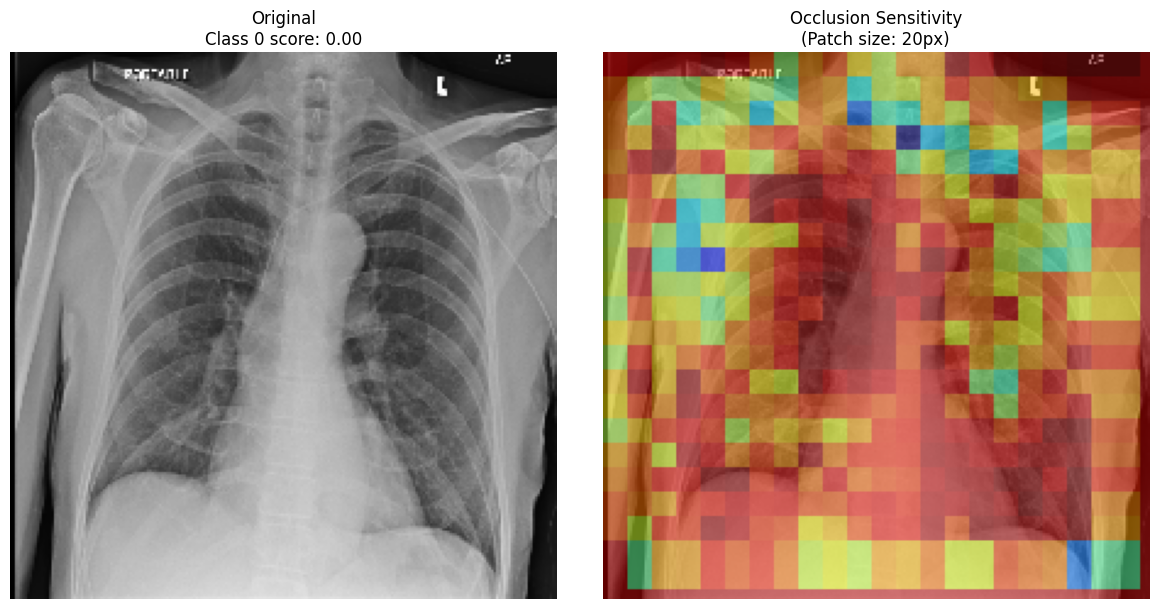

In [63]:
from tqdm import tqdm
def efficientnet_occlusion(image_path, model, class_idx=0, patch_size=20, stride=10):
    """Analyze how predictions change when covering different image regions"""
    # Load and preprocess image
    img = image.load_img(image_path, target_size=input_shape)
    img_array = image.img_to_array(img)
    original_img = img_array.copy()
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    
    # Get baseline prediction
    original_pred = model.predict(img_array)[0][class_idx]
    
    # Initialize heatmap
    heatmap = np.zeros(input_shape)
    
    # Create progress bar
    total_iterations = ((input_shape[0] - patch_size) // stride + 1) * ((input_shape[1] - patch_size) // stride + 1)
    
    with tqdm(total=total_iterations, desc="Generating occlusion map") as pbar:
        for y in range(0, input_shape[0] - patch_size + 1, stride):
            for x in range(0, input_shape[1] - patch_size + 1, stride):
                # Create occluded image
                temp_img = img_array.copy()
                temp_img[0, y:y+patch_size, x:x+patch_size, :] = 0
                
                # Get prediction with occlusion
                occluded_pred = model.predict(temp_img)[0][class_idx]
                
                # Store the prediction difference
                heatmap[y:y+patch_size, x:x+patch_size] = original_pred - occluded_pred
                
                pbar.update(1)
    
    # Normalize heatmap
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f'Original\nClass {class_idx} score: {original_pred:.2f}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title(f'Occlusion Sensitivity\n(Patch size: {patch_size}px)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return heatmap

# Usage
heatmap = efficientnet_occlusion(
    image_path=r"C:\Users\sarth\Downloads\lathaproject\images_010\images\00022892_004.png",
    model=model,
    class_idx=0,  # Change to analyze different classes
    patch_size=20,  # Size of occlusion patch
    stride=10  # Step size (smaller = more precise but slower)
)

Running occlusion analysis...


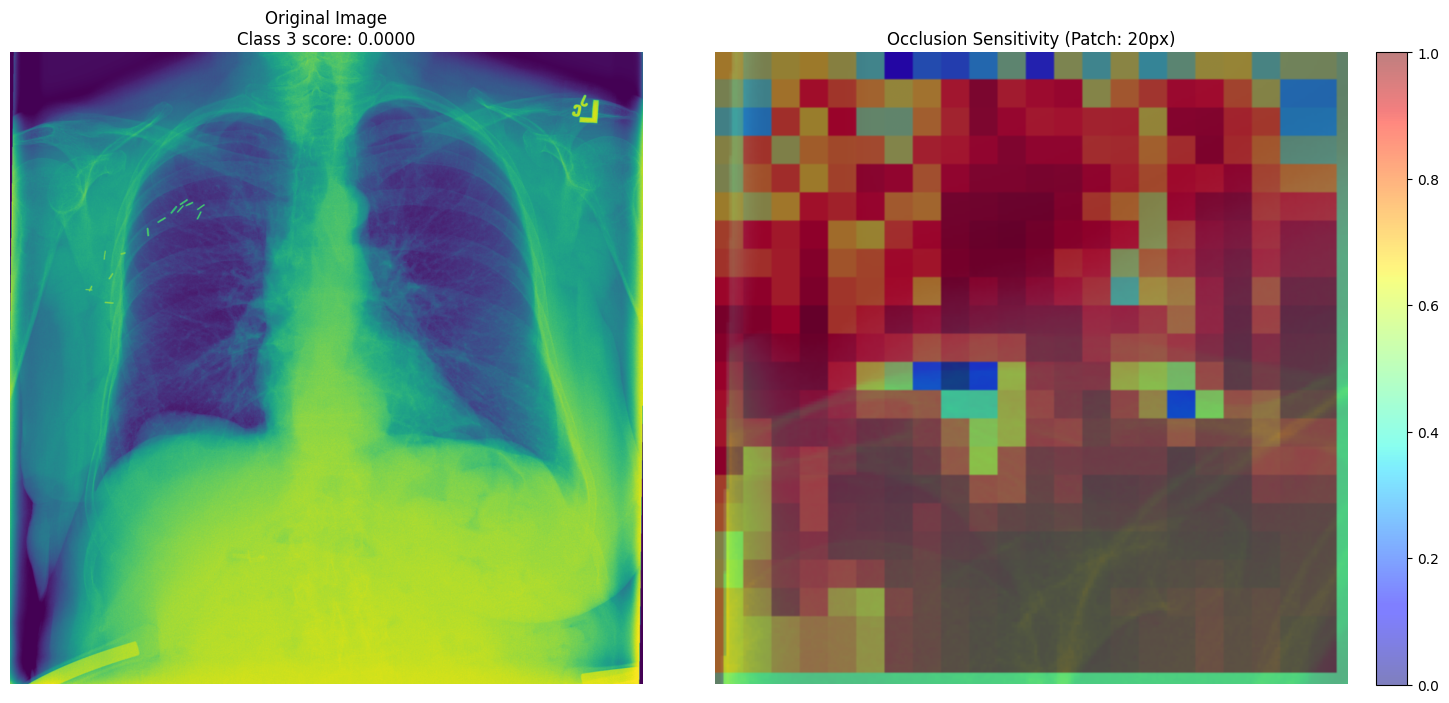

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
%matplotlib inline

def show_occlusion_results(image_path, model, class_idx=0, patch_size=20, stride=10):
    """Complete working occlusion analysis with visualization"""
    
    # 1. Load and preprocess image
    img = image.load_img(image_path, target_size=model.input_shape[1:3])
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    
    # 2. Get baseline prediction
    original_pred = model.predict(img_array, verbose=0)[0][class_idx]
    
    # 3. Initialize heatmap
    heatmap = np.zeros(model.input_shape[1:3])
    
    # 4. Perform occlusion analysis
    print("Running occlusion analysis...")
    for y in range(0, model.input_shape[1]-patch_size+1, stride):
        for x in range(0, model.input_shape[2]-patch_size+1, stride):
            # Create occluded image
            temp_img = img_array.copy()
            temp_img[0, y:y+patch_size, x:x+patch_size, :] = 0
            
            # Get prediction with occlusion
            occluded_pred = model.predict(temp_img, verbose=0)[0][class_idx]
            
            # Store the prediction difference
            heatmap[y:y+patch_size, x:x+patch_size] = original_pred - occluded_pred
    
    # 5. Normalize heatmap
    heatmap = (heatmap-heatmap.min())/(heatmap.max()-heatmap.min())
    
    # 6. Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Original image
    ax1.imshow(plt.imread(image_path))
    ax1.set_title(f'Original Image\nClass {class_idx} score: {original_pred:.4f}')
    ax1.axis('off')
    
    # Heatmap overlay
    ax2.imshow(plt.imread(image_path))
    heatmap_display = ax2.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.colorbar(heatmap_display, ax=ax2, fraction=0.046, pad=0.04)
    ax2.set_title(f'Occlusion Sensitivity (Patch: {patch_size}px)')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return heatmap

# Load your model (do this first)
model_path = r"C:\Users\sarth\Downloads\lathaproject\efficientnetb4_multilabel.h5"
model = tf.keras.models.load_model(model_path)

# Run analysis on your image
heatmap = show_occlusion_results(
    image_path=r"C:\Users\sarth\Downloads\lathaproject\images_001\images\00000003_003.png",
    model=model,  # Pass the loaded model
    class_idx=3,
    patch_size=20,
    stride=10
)

In [68]:
def show_occlusion_results(image_path, model, class_idx=None, patch_size=20, stride=10):
    """Occlusion analysis with auto class index selection if not provided"""
    
    # 1. Load and preprocess image
    img = image.load_img(image_path, target_size=model.input_shape[1:3])
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

    # 2. Get prediction
    preds = model.predict(img_array, verbose=0)[0]
    
    # 3. Auto-detect class if not provided or score is too low
    if class_idx is None or preds[class_idx] < 1e-6:
        class_idx = np.argmax(preds)
        print(f"Auto-selected class_idx: {class_idx} with score: {preds[class_idx]:.4f}")
    else:
        print(f"Using provided class_idx: {class_idx} with score: {preds[class_idx]:.4f}")
    
    original_pred = preds[class_idx]
    
    # 4. Initialize heatmap
    heatmap = np.zeros(model.input_shape[1:3])
    
    # 5. Perform occlusion analysis
    print("Running occlusion analysis...")
    for y in range(0, model.input_shape[1]-patch_size+1, stride):
        for x in range(0, model.input_shape[2]-patch_size+1, stride):
            # Create occluded image
            temp_img = img_array.copy()
            temp_img[0, y:y+patch_size, x:x+patch_size, :] = 0
            
            # Get prediction with occlusion
            occluded_pred = model.predict(temp_img, verbose=0)[0][class_idx]
            
            # Store the prediction difference
            heatmap[y:y+patch_size, x:x+patch_size] = original_pred - occluded_pred
    
    # 6. Normalize heatmap
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-6)
    
    # 7. Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Original image
    ax1.imshow(plt.imread(image_path))
    ax1.set_title(f'Original Image\nClass {class_idx} score: {original_pred:.4f}')
    ax1.axis('off')
    
    # Heatmap overlay
    ax2.imshow(plt.imread(image_path))
    heatmap_display = ax2.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.colorbar(heatmap_display, ax=ax2, fraction=0.046, pad=0.04)
    ax2.set_title(f'Occlusion Sensitivity (Patch: {patch_size}px)')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return heatmap


Auto-selected class_idx: 5 with score: 1.0000
Running occlusion analysis...


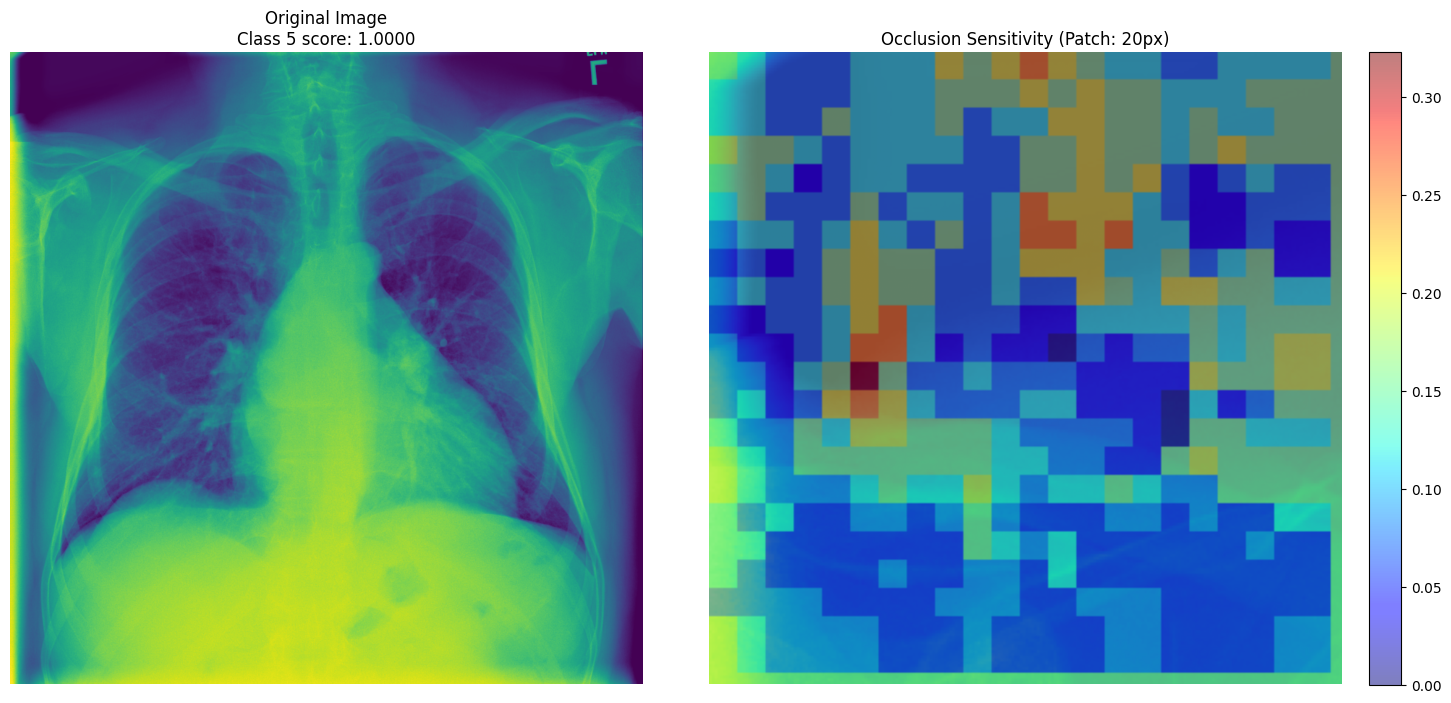

In [69]:
heatmap = show_occlusion_results(
    image_path=r"C:\Users\sarth\Downloads\lathaproject\images_001\images\00000001_000.png",
    model=model,  # Already loaded
    class_idx=None,  # Auto-select best class
    patch_size=20,
    stride=10
)


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


def show_occlusion_topk(image_path, model, class_names, top_k=3, patch_size=20, stride=10):
    # 1. Load & preprocess image
    img = image.load_img(image_path, target_size=model.input_shape[1:3])
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    
    # 2. Predict and get top-k class indices
    preds = model.predict(img_array, verbose=0)[0]
    top_k_indices = preds.argsort()[-top_k:][::-1]  # Top-k class indices
    
    # 3. Loop through top-k classes
    for class_idx in top_k_indices:
        original_pred = preds[class_idx]
        class_name = class_names[class_idx] if class_idx < len(class_names) else f"Class {class_idx}"

        # Heatmap init
        heatmap = np.zeros(model.input_shape[1:3])

        print(f"\nRunning occlusion for class {class_idx}: {class_name} (Score: {original_pred:.4f})")

        for y in range(0, model.input_shape[1]-patch_size+1, stride):
            for x in range(0, model.input_shape[2]-patch_size+1, stride):
                temp_img = img_array.copy()
                temp_img[0, y:y+patch_size, x:x+patch_size, :] = 0
                occluded_pred = model.predict(temp_img, verbose=0)[0][class_idx]
                heatmap[y:y+patch_size, x:x+patch_size] = original_pred - occluded_pred
        
        # Normalize heatmap
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

        # Plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
        ax1.imshow(plt.imread(image_path))
        ax1.set_title(f'Original Image\n{class_name} (Score: {original_pred:.4f})')
        ax1.axis('off')

        ax2.imshow(plt.imread(image_path))
        overlay = ax2.imshow(heatmap, cmap='jet', alpha=0.5)
        plt.colorbar(overlay, ax=ax2, fraction=0.046, pad=0.04)
        ax2.set_title(f'Occlusion Map for: {class_name}\n(Patch: {patch_size}px)')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()


In [3]:
# Load model
model = tf.keras.models.load_model(r"C:\Users\sarth\Downloads\lathaproject\efficientnetb4_multilabel.h5")

# Class labels from your dataset (same order as output units)
class_names = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule',
               'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema',
               'Fibrosis', 'Pleural_Thickening', 'Hernia', 'No Finding']

# Run analysis on image
show_occlusion_topk(
    image_path=r"C:\Users\sarth\Downloads\lathaproject\images_001\images\00000003_003.png",
    model=model,
    class_names=class_names,
    top_k=3,
    patch_size=20,
    stride=10
)



Running occlusion for class 5: Nodule (Score: 1.0000)


KeyboardInterrupt: 


Running occlusion for class 5: No Finding (Score: 1.0000)


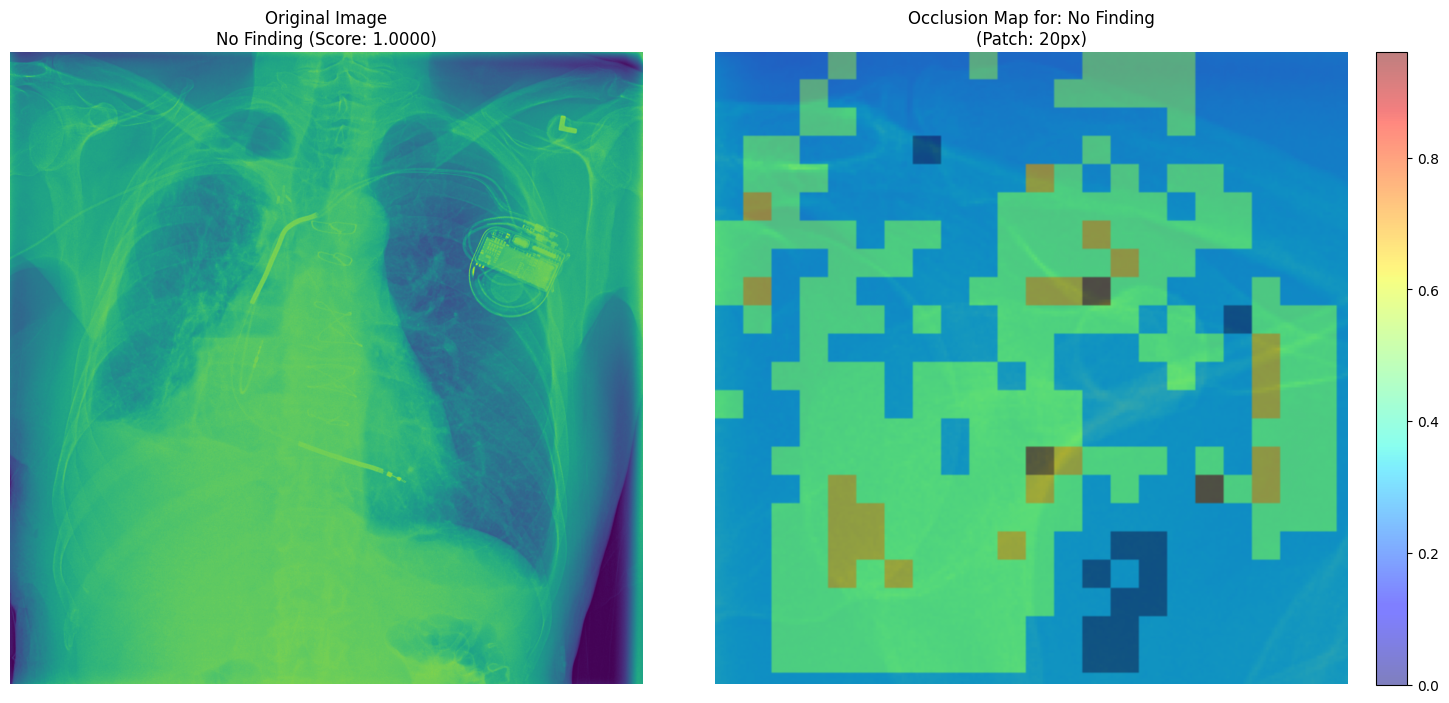


Running occlusion for class 4: Fibrosis (Score: 0.0000)


In [ ]:
["Pneumonia", "Pneumothorax", "Cardiomegaly", "Pleural_thickening", "Fibrosis", "No Finding"]
# Load model
model = tf.keras.models.load_model(r"C:\Users\sarth\Downloads\lathaproject\efficientnetb4_multilabel.h5")

# Class labels from your dataset (same order as output units)
class_names = ["Pneumonia", "Pneumothorax", "Cardiomegaly", "Pleural_thickening", "Fibrosis", "No Finding"]

# Run analysis on image
show_occlusion_topk(
    image_path=r"C:\Users\sarth\Downloads\lathaproject\images_001\images\00000013_015.png",
    model=model,
    class_names=class_names,
    top_k=3,
    patch_size=20,
    stride=10
)
